# Indian Liver Patient Records

Use random forest classifier on the Indian patient records to determine which patients have liver disease. This is a kaggle[https://www.kaggle.com/uciml/indian-liver-patient-records/home] competition.  The data is from Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. There are a number of machine learning papers that work on this data set;for example:
- Bendi Venkata Ramana, Prof. M. S. Prasad Babu and Prof. N. B. Venkateswarlu, "A Critical Comparative Study of Liver Patients from USA and INDIA: An Exploratory Analysis", International Journal of Computer Science Issues, (May 2012)
- Bendi Venkata Ramana and Prof. M.Surendra Prasad Babu, "Liver Classification Using Modified Rotation Forest" International Journal of Engineering Research and Development,  (June 2012)

## Outline <a id='outline'></a>

1. [Exploring data](#Exploringdata): 
     - Find missing data, and turn string data into catergory
     - Inspect the number of patients with and without liver disease among [age and gender groups](#genderage)

2. [Random Forest Classifier](#RF): 
     - [Hyperparameter tuning](#RF_hyper)
     - [Feature of importance](#RF_feature)
     - [Results](#RF_result): confusion matrix, most correct and most incorrect predictions for each class
     
3. [Conclusions](#con): 

In [1]:
# import libraries

import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.dataset import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss)
from sklearn.model_selection import RandomizedSearchCV

from IPython.display import display

import seaborn as sns
plt.style.use('ggplot')


## Exploring data <a id='Exploringdata'></a>

In [2]:
df_raw = pd.read_csv('indian_liver_patient.csv')
df_raw.head().T

,0,1,2,3,4
Age,65,62,62,58,72
Gender,Female,Male,Male,Male,Male
Total_Bilirubin,0.7,10.9,7.3,1,3.9
Direct_Bilirubin,0.1,5.5,4.1,0.4,2
Alkaline_Phosphotase,187,699,490,182,195
Alamine_Aminotransferase,16,64,60,14,27
Aspartate_Aminotransferase,18,100,68,20,59
Total_Protiens,6.8,7.5,7,6.8,7.3
Albumin,3.3,3.2,3.3,3.4,2.4
Albumin_and_Globulin_Ratio,0.9,0.74,0.89,1,0.4


In [3]:
df_raw.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


Two category columns: Age and Dataset(y value). In the Dataset 1 mean ill and 2 means healty. Albumin_and_Globulin_Ratio has missing values.

In [5]:
#Convert the Dataset columns into strings.
df_raw['Dataset'].replace({1:'ill',2:'healthy'}, inplace=True)
# converts all string columns into catergory
train_cats(df_raw)

In [6]:
df_raw['Dataset'].cat.categories

Index(['healthy', 'ill'], dtype='object')

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null category
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null category
dtypes: category(2), float64(5), int64(4)
memory usage: 42.4 KB


In [8]:
#Counting the number of patients
LD, NLD = df_raw['Dataset'].value_counts()
print('Number of patients diagnosed with liver disease: ',LD)
print('Number of patients not diagnosed with liver disease: ',NLD)
print(f'Ill patients in the dataset are {LD/(NLD+LD)*100} percent of the total')

Number of patients diagnosed with liver disease:  416
Number of patients not diagnosed with liver disease:  167
Ill patients in the dataset are 71.35506003430532 percent of the total


In [9]:
#replacing the null with median
#Scaling is require for logistic regression and neural network
df, y, nas, mapper = proc_df(df_raw, y_fld='Dataset', do_scale=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                              583 non-null float64
Gender                           583 non-null int8
Total_Bilirubin                  583 non-null float64
Direct_Bilirubin                 583 non-null float64
Alkaline_Phosphotase             583 non-null float64
Alamine_Aminotransferase         583 non-null float64
Aspartate_Aminotransferase       583 non-null float64
Total_Protiens                   583 non-null float64
Albumin                          583 non-null float64
Albumin_and_Globulin_Ratio       583 non-null float64
Albumin_and_Globulin_Ratio_na    583 non-null float64
dtypes: float64(10), int8(1)
memory usage: 46.2 KB


In [11]:
from scipy.cluster import hierarchy as hc

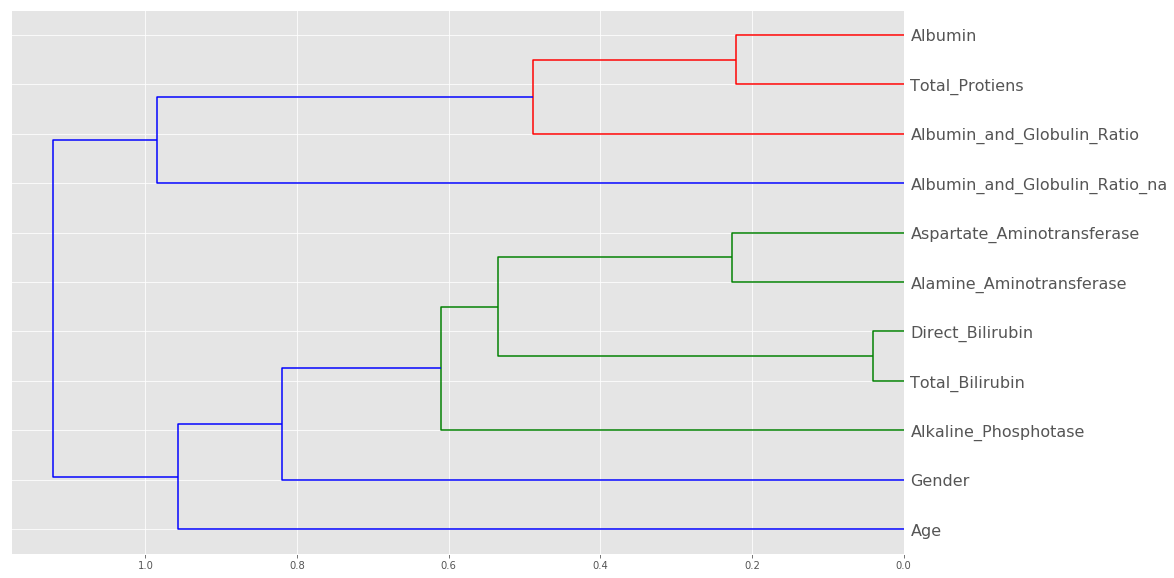

In [12]:
# Redundant Features
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

Strong correlation between Direct Bilirubin and Total Bilirubin, Albumin and Total_Proteins, and Aspartate_Aminotransferase and Alamine_Aminotransferase. We might be able to drop these. 

In [13]:
# split data into training and validation sets 
idxs = get_cv_idxs(len(df), val_pct=0.25, seed=52)
mask = np.zeros(len(df), dtype=bool)
mask[idxs] = True

In [14]:
x_trn = df[~mask]
x_val = df[mask]
y_trn = y[~mask]
y_val = y[mask]

In [15]:
_, nunique_trn = np.unique(y_trn, return_counts=True)
_, nunique_val = np.unique(y_val, return_counts=True)

print(f'Training data has {nunique_trn[1]/nunique_trn.sum()} ill patients')
print(f'Validataion data has {nunique_val[1]/nunique_val.sum()} ill patients')

Training data has 0.7100456621004566 ill patients
Validataion data has 0.7241379310344828 ill patients


In [16]:
#define score report function for RF and LG
def print_score(m):
    y_trn_prob = m.predict_proba(x_trn)
    y_val_prob = m.predict_proba(x_val)
    res = [log_loss(y_trn, y_trn_prob), log_loss(y_val, y_val_prob),
          m.score(x_trn, y_trn), m.score(x_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print('train loss\t val loss \t train accuracy \t val accuracy')
    print(res)

## Random Forest Classifier <a id='RF'></a>

In [17]:
#baseline RF 
mrf = RandomForestClassifier(n_jobs=-1)
%time mrf.fit(x_trn,y_trn)
print_score(mrf)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 111 ms
train loss	 val loss 	 train accuracy 	 val accuracy
[0.15823300657737305, 1.158720552159259, 0.9885844748858448, 0.7586206896551724]


training score is better than the validation score, we are over fitting

In [18]:
mrf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

### Hyperparameters tuning <a id='RF_hyper'></a>

In [19]:
param_dist = {'n_estimators':range(10,70,10),
              'max_depth': [3, None],
              'max_features': [0.5, 1, 'log2','sqrt','auto'],
              'min_samples_leaf': range(1, 8),
              'criterion': ["gini", "entropy"]}

In [20]:
n_iter_search = 20
random_search = RandomizedSearchCV(mrf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

In [21]:
random_search.fit(x_trn, y_trn);

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [22]:
random_search.best_score_, random_search.best_params_

(0.7123287671232876,
 {'n_estimators': 60,
  'min_samples_leaf': 6,
  'max_features': 'auto',
  'max_depth': 3,
  'criterion': 'entropy'})

In [23]:
mrf = RandomForestClassifier(n_estimators=60,min_samples_leaf=6, 
                             max_features= 'auto', max_depth=3, 
                             bootstrap=True, criterion='entropy', n_jobs=-1)
mrf.fit(x_trn,y_trn)
print_score(mrf)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.4808925537102735, 0.49220391760289345, 0.7214611872146118, 0.7172413793103448]


### RF Feature of importance <a id='RF_feature'></a>

Feature of importance score for each column is calculated by generating another dataset with the data in that column in randomized order. Calculate the average change in the prediction results of the two datasets. The average change for each columns are ranked from largest to lowest with the largest means highest feature of importance. Columns with low feature of importances can be dropped. 


In [24]:
# use fastai command to calculate feature of importance
fi = rf_feat_importance(mrf, x_trn)
fi

,cols,imp
3,Direct_Bilirubin,0.223052
2,Total_Bilirubin,0.182015
5,Alamine_Aminotransferase,0.155426
6,Aspartate_Aminotransferase,0.132975
4,Alkaline_Phosphotase,0.127471
0,Age,0.073203
8,Albumin,0.037953
9,Albumin_and_Globulin_Ratio,0.036616
7,Total_Protiens,0.029612
1,Gender,0.001675


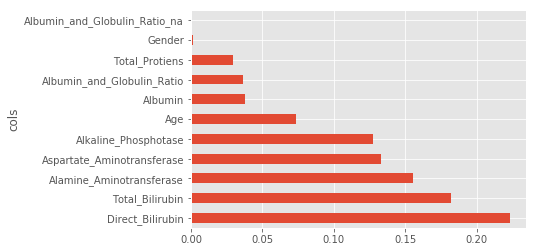

In [25]:
fi.plot('cols', 'imp', 'barh', legend=False)

In [26]:
# drop the last 5 columns
to_keep = fi[fi.imp>0.05].cols; 
df_keep = df[to_keep].copy()

In [27]:
x_trn = df[~mask]
x_val = df[mask]

In [28]:
mrf = RandomForestClassifier(n_estimators=30,min_samples_leaf=3, 
                             max_features= 1, max_depth=3, 
                             bootstrap=True, criterion='entropy', n_jobs=-1, oob_score=True)
mrf.fit(x_trn,y_trn)
print_score(mrf)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.5121090435398271, 0.5120226754544109, 0.7100456621004566, 0.7241379310344828, 0.7100456621004566]


From the dendogram, there are strong correlation between Direct Bilirubin and Total Bilirubin, Albumin and Total_Proteins, and Aspartate_Aminotransferase and Alamine_Aminotransferase. The middle two were already dropped due to low feature of importance. We will try to drop the other four features by considering oob_score.

In [29]:
def get_oob(df_keep):
    
    mrf.fit(x_trn, y_trn)
    return mrf.oob_score_

In [30]:
# oob before dropping
get_oob(df_keep)

0.7100456621004566

In [31]:
# removing one feature at a time
for drop_fea in ('Total_Bilirubin', 'Direct_Bilirubin', 
                 'Aspartate_Aminotransferase', 'Alamine_Aminotransferase'):
    print(drop_fea, get_oob(x_trn.drop(drop_fea, axis=1)))

Total_Bilirubin 0.7100456621004566
Direct_Bilirubin 0.7100456621004566
Aspartate_Aminotransferase 0.7077625570776256
Alamine_Aminotransferase 0.7100456621004566


In [32]:
x_trn = x_trn.drop('Aspartate_Aminotransferase', axis=1)
x_val = x_val.drop('Aspartate_Aminotransferase', axis=1)

In [33]:
mrf.fit(x_trn,y_trn)
print_score(mrf)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.5038445325814594, 0.4994273016260391, 0.7100456621004566, 0.7241379310344828, 0.7054794520547946]


### Analyzing RF Results <a id='RF_result'></a>

In [34]:
trn_preds = mrf.predict(x_trn)
trn_proba = mrf.predict_proba(x_trn)
val_preds = mrf.predict(x_val)
val_proba = mrf.predict_proba(x_val)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification Report validation set: 
               precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        40
         Ill       0.72      1.00      0.84       105

   micro avg       0.72      0.72      0.72       145
   macro avg       0.36      0.50      0.42       145
weighted avg       0.52      0.72      0.61       145



([<matplotlib.axis.YTick at 0x1d76b9b6e10>,
 <a list of 2 Text yticklabel objects>)

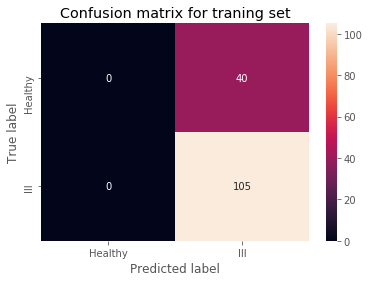

In [35]:
#print('Confusion Matrix: \n', confusion_matrix(y_val,preds))
print('Classification Report validation set: \n', classification_report(y_val,val_preds, 
                                                        target_names=['Healthy', 'Ill']))

sns.heatmap(confusion_matrix(y_val,val_preds),annot=True,fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for traning set')
tick_marks = np.arange(2) + 0.5
plt.xticks(tick_marks, ['Healthy','Ill'])
plt.yticks(tick_marks, ['Healthy','Ill'])

In diagnosis, the model should minimize false negative, which is labeling the patients with liver disease as healthy.

We compare the model prediction to normal blood panel analysis. To help analyzing the data, we categorize each blood panel into range labeld low, normal, high. 

In [36]:
features = df_raw.columns.drop(['Age','Gender','Dataset']);features

Index(['Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [37]:
# blood test normal range
bins_dict = {'Total_Bilirubin': [0, 0.1, 1.2, np.inf],
             'Direct_Bilirubin': [0, 0.3, np.inf],
             'Alkaline_Phosphotase': [0, 20, 140, np.inf],
             'Alamine_Aminotransferase': [0, 10, 40, np.inf],
             'Aspartate_Aminotransferase': [0, 7, 56, np.inf],
             'Total_Protiens': [0, 6, 8.3, np.inf],
             'Albumin': [0, 3.5, 5.5, np.inf],
             'Albumin_and_Globulin_Ratio': [0, 0.8, 2.0, np.inf]
             }

In [38]:
def ana_blood(col):
    """convert each blood panel into catergory"""
    if len(bins_dict[col.name]) == 3:
        labels = ['normal','high']
    else:
        labels = ['low','normal','high'] 
    return pd.cut(col,bins=bins_dict[col.name], labels=labels)

In [39]:
df_analyse = df_raw[mask].copy()
df_analyse.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,ill
7,29,Female,0.9,0.3,202,14,11,6.7,3.6,1.10,ill
8,17,Male,0.9,0.3,202,22,19,7.4,4.1,1.20,healthy
11,72,Male,2.7,1.3,260,31,56,7.4,3.0,0.60,ill
19,40,Female,0.9,0.3,293,232,245,6.8,3.1,0.80,ill


In [40]:
for fea in features:
    df_analyse[fea] = ana_blood(df_analyse[fea])

In [41]:
df_analyse['prediction'] = val_preds
df_analyse['predict_proba'] = val_proba[:,1]
df_analyse['prediction'] = df_analyse['prediction'].astype('category')
df_analyse['prediction']=df_analyse['prediction'].cat.rename_categories({0:'healthy', 1:'ill'})

In [42]:
df_analyse.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,prediction,predict_proba
2,62,Male,high,high,high,high,high,normal,low,normal,ill,ill,0.881677
7,29,Female,normal,normal,high,normal,normal,normal,normal,normal,ill,ill,0.586099
8,17,Male,normal,normal,high,normal,normal,normal,normal,normal,healthy,ill,0.570645
11,72,Male,high,high,high,normal,normal,normal,low,low,ill,ill,0.868919
19,40,Female,normal,normal,high,high,high,normal,low,low,ill,ill,0.815728


In [43]:
def show_result_ex(is_correct, ran, val_preds, y_val):
    """ return random index of correct or in_correct classification"""
    idx = np.where((val_preds == y_val)==is_correct)[0]
    idx = np.random.choice(idx, min(len(idx),6)) if ran==True else idx
    return idx

In [44]:
print('Random example of correctly classified')
df_analyse.iloc[show_result_ex(True, True, val_preds, y_val)].head()

Random example of correctly classified


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,prediction,predict_proba
159,50,Male,normal,high,high,normal,normal,normal,normal,normal,ill,ill,0.703952
11,72,Male,high,high,high,normal,normal,normal,low,low,ill,ill,0.868919
294,22,Male,high,high,high,normal,normal,normal,normal,normal,ill,ill,0.707201
211,42,Male,high,high,high,high,high,normal,low,low,ill,ill,0.836391
25,34,Male,high,high,high,high,high,low,low,normal,ill,ill,0.929739


In [45]:
print('Most Incorrectly classified as Ill')
idx = np.where(val_preds != y_val)[0]

df_analyse.iloc[show_result_ex(False, False, val_preds, y_val)
               ][df_analyse['Dataset']=='healthy'].sort_values('predict_proba', 
                                                               ascending=False).head(5)

Most Incorrectly classified as Ill


C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,prediction,predict_proba
114,50,Male,high,high,high,high,high,low,low,low,healthy,ill,0.918351
475,38,Male,high,high,high,high,normal,normal,normal,normal,healthy,ill,0.883016
33,38,Female,high,high,high,high,high,low,low,low,healthy,ill,0.825063
534,39,Male,high,high,high,high,high,normal,normal,normal,healthy,ill,0.762425
411,23,Female,high,high,high,normal,normal,normal,low,low,healthy,ill,0.750812


In [46]:
print('Most Incorrectly classified as Healthy')
idx = np.where(val_preds != y_val)[0]

df_analyse.iloc[show_result_ex(False, False, val_preds, y_val)
               ][df_analyse['Dataset']=='ill'].sort_values('predict_proba', 
                                                               ascending=False).head(5)

Most Incorrectly classified as Healthy


C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,prediction,predict_proba


The model  have zero number of ill patients, which is incorrectly classified as healthy. The reason the model thinks the patient is healthy or ill was because most of their blood tests are normal/high. Interestingly, most of these patients are females.

## Conclusions <a id='con'></a>

Random forest classifier achieved 73% accuracy. Features included in the models are Total_Bilirubin, Direct_Bilirubin, Alkaline_Phosphotase, Alamine_Aminotransferase.

In the future, I will use neural network for this task and compare the results.
